# Predicting Genre by Song Lyrics

For this project I will apply various natural language processing techniques to a corpus of song lyrics. The first section of this project will use unsupervised models to cluster each song to see if I can derive any underlying patterns to the lyrics. The second section will employ supervised models to determine to what extent the models are able to predict a song's genre from its lyrics.

If we are able to produce a working model, there are ample use-cases for applying that model to the lyrics of a new song. As shown below, labeling each artist's genre by hand is very tedious, so automating that would save a lot of time and effort.

## Preprocessing

In [1]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation, MeanShift, SpectralClustering, estimate_bandwidth
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from sklearn.decomposition import NMF
import spacy
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
nlp = spacy.load('en')
from sklearn.svm import SVC

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/usr/local/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/usr/local/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it wi

In [2]:
# Read in the csv to a data frame.
df = pd.read_csv('songdata.csv')
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


### Genre

Manually assign genre to the twenty artists with the most songs in the dataset.

In [3]:
df.artist.value_counts().index[:20]

Index(['Donna Summer', 'Gordon Lightfoot', 'Bob Dylan', 'George Strait',
       'Loretta Lynn', 'Reba Mcentire', 'Alabama', 'Cher', 'Dean Martin',
       'Chaka Khan', 'Neil Young', 'Hank Williams Jr.', 'Cliff Richard',
       'America', 'Nazareth', 'Indigo Girls', 'Johnny Cash', 'Kiss',
       'Chris Rea', 'Bon Jovi'],
      dtype='object')

In [4]:
# Tag genres for each artist
df['genre'] = np.where(df['artist'] == 'Donna Summer', 'disco',
                       np.where((df['artist'] == 'Gordon Lightfoot') |
                                (df['artist'] == 'Bob Dylan') |
                                (df.artist == 'Indigo Girls'), 'folk',
                                np.where((df['artist'] == 'George Strait') |
                                         (df.artist == 'Reba Mcentire') |
                                         (df['artist'] == 'Alabama') |
                                         (df.artist == 'Loretta Lynn') |
                                         (df.artist == 'Hank Williams Jr.') |
                                         (df.artist == 'Johnny Cash'), 'country',
                                         np.where((df.artist == 'Cher') |
                                                  (df.artist ==
                                                   'Cliff Richard'), 'pop',
                                                  np.where(df.artist == 'Chaka Khan', 'r&b',
                                                           np.where(df.artist == 'Dean Martin', 'swing',
                                                                    np.where((df.artist == 'Neil Young') |
                                                                             (df.artist == 'America') |
                                                                             (df.artist ==
                                                                              'Nazareth') |
                                                                             (df.artist == 'Kiss') |
                                                                             (df.artist ==
                                                                              'Chris Rea') |
                                                                             (df.artist == 'Bon Jovi'), 'rock', 0))))
                                         )))

In [5]:
df.genre.value_counts()

0          53939
country     1117
rock        1099
folk         561
pop          371
disco        191
swing        186
r&b          186
Name: genre, dtype: int64

In [6]:
artist_list = list(df.artist.value_counts().index[:20])
print(artist_list)

['Donna Summer', 'Gordon Lightfoot', 'Bob Dylan', 'George Strait', 'Loretta Lynn', 'Reba Mcentire', 'Alabama', 'Cher', 'Dean Martin', 'Chaka Khan', 'Neil Young', 'Hank Williams Jr.', 'Cliff Richard', 'America', 'Nazareth', 'Indigo Girls', 'Johnny Cash', 'Kiss', 'Chris Rea', 'Bon Jovi']


In [7]:
# Create new subset df of just our labeled artists and remove extraneous columns.
df['twenty_artists'] = np.where(np.isin(df['artist'], artist_list), 1, 0)
df_sub = df[df.twenty_artists == 1]

In [8]:
df_sub.tail()

,artist,song,link,text,genre,twenty_artists
50506,Reba Mcentire,Old Man River,/r/reba+mcentire/old+man+river_20114622.html,"(ronny scaife, danny hogan) \n \nCool breeze...",country,1
50507,Reba Mcentire,On My Own,/r/reba+mcentire/on+my+own_20114592.html,So many times I said it was forever \nSaid ou...,country,1
50508,Reba Mcentire,"One Child, One Day",/r/reba+mcentire/one+child+one+day_20114569.html,"Three wise men, a shining star \nA mother and...",country,1
50509,Reba Mcentire,One Promise Too Late,/r/reba+mcentire/one+promise+too+late_20114392...,I would have waited forever \nIf I'd known th...,country,1
50510,Reba Mcentire,One Thin Dime,/r/reba+mcentire/one+thin+dime_20114664.html,Your mind's made up \nYou're gonna leave \nN...,country,1


In [9]:
print('Number of unique genres:', df_sub.genre.nunique())

Number of unique genres: 7


In [10]:
# Inspect some samples.
print(df_sub.text[1:2].values, '\n')
print(df_sub.text[45:46].values, '\n')

["I thought it was forever  \nI thought it would last  \nGotta try to make it  \nA page of my past  \nYou didn't even say goodbye  \nWhen you slammed that door  \n  \nNow I'm lyin' here alone  \nIn what once was our bed  \nTrying to forget  \nAll the cruel words you said  \nAll the radio was playing  \nWhat once was our favorite song  \n  \nOh enough is enough I won't take anymore  \nI'm picking myself up off the floor  \n  \n'Cause you can't keep a good man down  \nYou can't keep a good man down  \nOh no you can't keep a good man down  \nSugar, you can't keep a good man down  \n  \nGonna dress up in my finest  \nClothes that I own  \nAnd take it to the streets  \nI won't be lonely for long  \nGonna put on my best moves  \nOn every single woman I see  \n  \nNow you thought you could break me  \nAdd me to your list  \nNotch me on your gun  \nLet me tell you this  \nI've got news for you baby  \nI don't break that easily  \n  \n'Cause you can't keep a good man down  \nYou can't keep a go

### Clean Text and Split

In [11]:
# Need to remove newlines, but it doesn't seem like there's too much else to worry about.
def text_cleaner(text):
    text = re.sub(r'Chorus', ' ', text)
    text = re.sub(r'Verse', ' ', text)
    text = ' '.join(text.split())
    
    return text

df_sub['clean_text'] = df_sub.text.apply(lambda row: text_cleaner(row))
df_sub.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,artist,song,link,text,genre,twenty_artists,clean_text
361,Alabama,Calling All Angels,/a/alabama/calling+all+angels_20005071.html,"Calling, calling all angels, oh I'm calling, c...",country,1,"Calling, calling all angels, oh I'm calling, c..."
362,Alabama,Can't Keep A Good Man Down,/a/alabama/cant+keep+a+good+man+down_20522156....,I thought it was forever \nI thought it would...,country,1,I thought it was forever I thought it would la...
363,Alabama,Carolina Mountain Dew,/a/alabama/carolina+mountain+dew_20175804.html,Somewhere in the mountains......... In norther...,country,1,Somewhere in the mountains......... In norther...
364,Alabama,Christmas In Dixie,/a/alabama/christmas+in+dixie_20005147.html,"By now in New York City, there's snow on the g...",country,1,"By now in New York City, there's snow on the g..."
365,Alabama,Christmas In Your Arms,/a/alabama/christmas+in+your+arms_20005047.html,All my friends are asking me where I plan to s...,country,1,All my friends are asking me where I plan to s...


In [12]:
df_sub[df_sub.artist == 'Cher'].clean_text[2:4].values

array(['She left her neighborhood In which everyone was filthy rich She left her parent\'s home And strained with a vagabond Who made piles of love she never heard And she believed his every word She left no forwarding address Just took her youth and happiness As with the boy she vanished in The secret sweetness of their sin Oh, young girl Oh, young girl of sixteen Child of spring-time Still green Lying there by the road He told her, "love demanded space" So they roamed from place to place Although she realized she\'d sinned She grew caution to the wind As she followed him around While he slowly dragged her down So overpowering was her love The it had made a captive of The young girl\'s heart and soul and mind In other words: love drove her blind Oh, young girl Oh, young girl of sixteen Child of spring-time Still green Laying there by the road Too much emotion for a girl She let her heart become her world What world that God has never rocked For a sunder we are taught Had she been wise

In [13]:
# Split off 25% as holdout group.
from sklearn.model_selection import train_test_split
df_sub_train, df_sub_test = train_test_split(df_sub, test_size=.25, random_state=3)

## Unsupervised Approaches

### TFIDF and CountVectorizer

In [14]:
df_sub_train1 = df_sub_train[['artist', 'genre', 'clean_text']]

In [15]:
df_sub_train1.head()

,artist,genre,clean_text
17235,Reba Mcentire,country,"When I heard that familiar voice, My heart sto..."
13592,Nazareth,rock,"May the sun, the sun shine bright May the sun ..."
27269,Cher,pop,Do you believe? Do you believe? Do you believe...
26183,Bon Jovi,rock,Looking like a train wreck Sipping on her long...
1755,Bon Jovi,rock,When you get to the bottom You go back to the ...


#### TFIDF

In [16]:
# Having manually grid-searched quite a bit, this seems to give us the best featurespace. 
vectorizer = TfidfVectorizer(max_df=0.7,
                             min_df=20,
                             stop_words='english',
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2'
                            )

In [17]:
lyrics_tfidf = vectorizer.fit_transform(df_sub_train1.clean_text)
print('Number of features: {}'.format(lyrics_tfidf.get_shape()[1]))

Number of features: 1170


In [18]:
lyrics_tfidf_csr = lyrics_tfidf.tocsr()
lyrics_norm = normalize(lyrics_tfidf_csr.toarray())

##### K-Means

In [19]:
df_sub_train1.artist.describe()

count              2783
unique               20
top       George Strait
freq                149
Name: artist, dtype: object

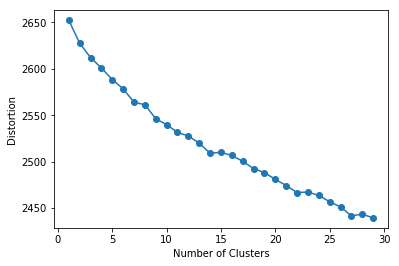

In [20]:
# Use the elbow method to see how many clusters kmeans is detecting.
distortions = []
for i in range(1, 30):
    km = KMeans(n_clusters=i,
                init='k-means++',
                random_state=3)
    km.fit(lyrics_norm)
    distortions.append(km.inertia_)
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

No distinguishable change in the rate of decrease of distortion at 7 clusters.

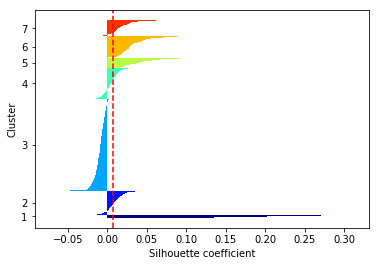

In [21]:
km = KMeans(n_clusters=7,
            init='k-means++',
            random_state=3)
y_km = km.fit_predict(lyrics_norm)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(lyrics_norm, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

Silhoutte score for 7 distinct clusters is very, very low, meaning we do not have distinct clusters.

##### Mean Shift

In [22]:
bandwidth = estimate_bandwidth(lyrics_norm, quantile=0.1)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(lyrics_norm)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))
print('Number of estimated clusters: {}'.format(n_clusters_))

Number of estimated clusters: 1


Mean-shift clearing is also not detecting distinct clusters.

##### Spectral Clustering

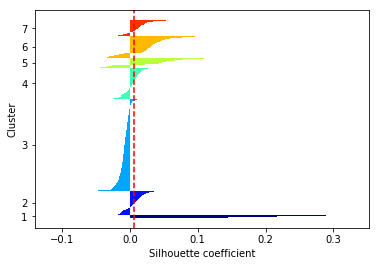

In [23]:
sc = SpectralClustering(n_clusters=7,
            random_state=3)
y_sc = sc.fit_predict(lyrics_norm)

cluster_labels = np.unique(y_sc)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(lyrics_norm, y_sc, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

#### Stemmed CountVectorizer

A harsher Stemmer combined with CountVectorizer may create a better bag of words.

In [24]:
import nltk.stem

/usr/local/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [25]:
# Snowball stemmer will be harsher in trimming words.
english_stemmer = nltk.stem.SnowballStemmer('english')

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

In [26]:
vectorizer = StemmedCountVectorizer(min_df=10, max_df=.7, stop_words='english')

In [27]:
X_dtm2 = vectorizer.fit_transform(df_sub_train1.clean_text)
print('Number of features: {}'.format(X_dtm2.get_shape()[1]))

X_dtm_norm2 = normalize(X_dtm2.toarray())

Number of features: 1676


##### K-Means

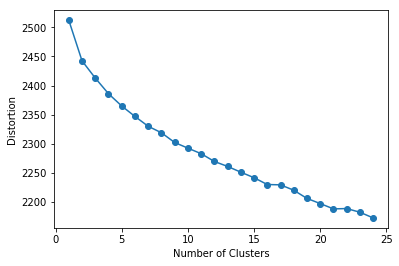

In [28]:
distortions = []
for i in range(1, 25):
    km = KMeans(n_clusters=i,
                init='k-means++',
                random_state=3)
    km.fit(X_dtm_norm2)
    distortions.append(km.inertia_)
plt.plot(range(1, 25), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

Still no "elbow" to indicate 7 clusters.

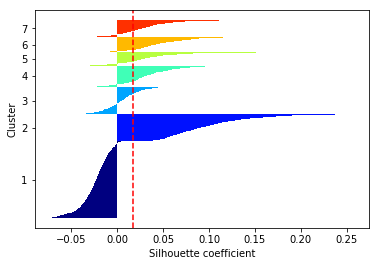

In [29]:
km = KMeans(n_clusters=7,
            init='k-means++',
            random_state=3)
y_km = km.fit_predict(X_dtm_norm2)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_dtm_norm2, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

#### Dimensionality Reduction

Using SVD to compress our featurespace may improve performance for K-Means.

In [30]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

##### Singular Value Decomposition with TFIDF

In [31]:
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=10,
                             stop_words='english',
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2'
                             )

lyrics_tfidf = vectorizer.fit_transform(df_sub_train1.clean_text)
print('Number of features: {}'.format(lyrics_tfidf.get_shape()[1]))

lyrics_tfidf_csr = lyrics_tfidf.tocsr()
lyrics_norm = normalize(lyrics_tfidf_csr.toarray())

Number of features: 1939


In [32]:
svd = TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_lsa = lsa.fit_transform(lyrics_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 66.58478949014


##### K-Means

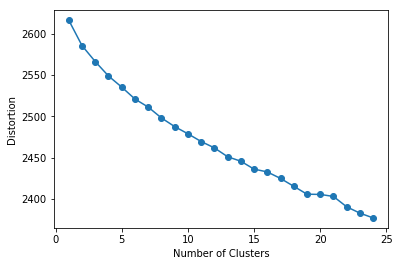

In [33]:
distortions = []
for i in range(1, 25):
    km = KMeans(n_clusters=i,
                init='k-means++',
                random_state=3)
    km.fit(X_lsa)
    distortions.append(km.inertia_)
plt.plot(range(1, 25), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

##### SVD with CountVectorizer

In [34]:
vect = CountVectorizer(max_df=0.2, min_df=10, stop_words='english')
X_dtm = vect.fit_transform(df_sub_train1.clean_text)
print('Number of features: {}'.format(X_dtm.get_shape()[1]))

Number of features: 1916


In [35]:
svd = TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_dtm_lsa = lsa.fit_transform(X_dtm)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 83.72558208930302


##### K-Means

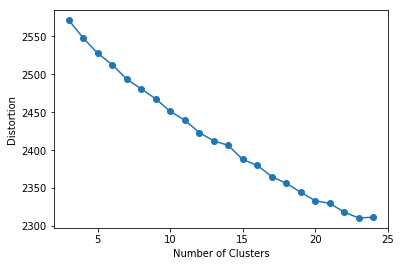

In [36]:
distortions = []
for i in range(3, 25):
    km = KMeans(n_clusters=i,
                init='k-means++',
                random_state=3)
    km.fit(X_dtm_lsa)
    distortions.append(km.inertia_)
plt.plot(range(3, 25), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

#### Initial Unsupervised Conclusions

KMeans, Mean-shift, and Spectral Clustering all perform quite poorly on the text data, regardless of how we create the featurespace. The data is too sparse for any of those models to detect the number of clusters we are looking for even when applying Singular Value Decomposition to reduce the features drastically.

### Latent Dirichlet Allocation (LDA)

Since K-Means, Mean-shift, and Spectral Clustering do not do well with sparse data, I will implement two topic modeling techniques that are better suited for this task, Latent Dirichlet Allocation and Non-negative Matrix Factorization.

In [37]:
df_sub_train1.head()

,artist,genre,clean_text
17235,Reba Mcentire,country,"When I heard that familiar voice, My heart sto..."
13592,Nazareth,rock,"May the sun, the sun shine bright May the sun ..."
27269,Cher,pop,Do you believe? Do you believe? Do you believe...
26183,Bon Jovi,rock,Looking like a train wreck Sipping on her long...
1755,Bon Jovi,rock,When you get to the bottom You go back to the ...


In [38]:
docs = np.array(df_sub_train1.clean_text)

In [39]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewpokorny/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
from nltk.stem.porter import PorterStemmer

In [41]:
# Prepare the docs with a porter stemmer and remove shorter words

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = str(docs[idx]).lower()
        docs[idx] = tokenizer.tokenize(docs[idx])
        
    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
#     lemmatizer = WordNetLemmatizer()
#     docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    
    # Get only stems.
    p_stemmer = PorterStemmer()
    docs = [[p_stemmer.stem(i) for i in doc] for doc in docs]
    
    return docs

In [42]:
docs = docs_preprocessor(docs)
docs[5][:10]

['sister',
 'head',
 'alabama',
 'better',
 'think',
 'fast',
 'wind',
 'gonna',
 'pick',
 'rain']

In [43]:
from gensim.models.phrases import Phrases, Phraser

# Add bigrams to our docs.
bigram = Phrases(docs)
print(len(bigram[docs[5]]))
print(docs[5][:15])

/usr/local/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


142
['sister', 'head', 'alabama', 'better', 'think', 'fast', 'wind', 'gonna', 'pick', 'rain', 'slack', 'head', 'down', 'georgia', 'lose']


In [44]:
for i in range(len(docs)):
    for token in bigram[docs[i]]:
        if '_' in token:
            docs[i].append(token)

In [45]:
from gensim.corpora import Dictionary

In [46]:
dictionary = Dictionary(docs)
print('Number of unique words in initial documents:', len(dictionary))

Number of unique words in initial documents: 9949


In [47]:
# Filter out words that occur less than 5 documents or more than 20% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words after removing rare and common words: 3003


In [48]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [49]:
# BoW count for every index, matches on the dictionary.
corpus[0]

[(0, 1),
 (1, 2),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 2),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1)]

In [50]:
print('Number of unique tokens:', len(dictionary))

Number of unique tokens: 3003


In [51]:
print('Number of documents:', len(corpus))

Number of documents: 2783


In [52]:
from gensim.models import LdaModel

In [53]:
# Fit LDA model and visualize the topics with pyLDAvis.
num_topics = 7
chunksize = 200
passes = 20
iterations = 400
eval_every = 1

# Make an index to word dictionary.
temp = dictionary[0]  # can ignore 
id2word = dictionary.id2token

model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize,
                 alpha='auto', eta='auto',
                 iterations=iterations, num_topics=num_topics,
                 passes=passes, eval_every=eval_every)

pyLDAvis.gensim.prepare(model, corpus, dictionary, mds='tsne')

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5     -24.740992 -65.396896       1        1  37.680820
3     -53.019955 -38.865177       2        1  15.780822
0     -44.182125  -1.109381       3        1  12.728980
4      -7.063179  10.116592       4        1  12.311082
6      21.216324 -16.414785       5        1   9.536865
2     -15.902141 -27.640707       6        1   6.567929
1      12.375019 -54.171909       7        1   5.393509, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
98    Default  1954.000000       babi  1954.000000  30.0000  30.0000
343   Default  1112.000000       need  1112.000000  29.0000  29.0000
166   Default  1535.000000      gonna  1535.000000  28.0000  28.0000
131   Default   893.000000       yeah   893.000000  27.0000  27.0000
11    Default   858.000000       girl   858.000000  26.0000  26.0000
33    Default   636.000000    tonight   636.000000  25.0000  25.0000
1     Default   674.000000     believ   674.000000  24.0000  24.0000
111   Default   995.000000      littl   995.000000  23.0000  23.0000
180   Default  1082.000000       said  1082.000000  22.0000  22.0000
200   Default   688.000000       blue   688.000000  21.0000  21.0000
233   Default  1061.000000       good  1061.000000  20.0000  20.0000
169   Default   999.000000       home   999.000000  19.0000  19.0000
242   Default  1070.000000       more  1070.000000  18.0000  18.0000
90    Default   488.000000     realli   488.000000  17.0000  17.0000
337   Default   483.000000       danc   483.000000  16.0000  16.0000
117   Default   659.000000       over   659.000000  15.0000  15.0000
543   Default   616.000000       song   616.000000  14.0000  14.0000
31    Default   443.000000       stop   443.000000  13.0000  13.0000
350   Default   419.000000      wanna   419.000000  12.0000  12.0000
409   Default   507.000000       sing   507.000000  11.0000  11.0000
99    Default   766.000000       call   766.000000  10.0000  10.0000
88    Default   363.000000     enough   363.000000   9.0000   9.0000
124   Default   438.000000       talk   438.000000   8.0000   8.0000
302   Default   764.000000      world   764.000000   7.0000   7.0000
30    Default   987.000000       some   987.000000   6.0000   6.0000
469   Default   297.000000  everybodi   297.000000   5.0000   5.0000
140   Default   294.000000       ride   294.000000   4.0000   4.0000
1154  Default   299.000000      honey   299.000000   3.0000   3.0000
42    Default   876.000000      again   876.000000   2.0000   2.0000
129   Default   398.000000      woman   398.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
1855   Topic7    50.692364      front    51.536301   2.9035  -5.3339
1486   Topic7    50.366962     drivin    51.211014   2.9034  -5.3404
2413   Topic7    46.346626     legend    47.188148   2.9020  -5.4235
2585   Topic7    46.041759      bobbi    46.885986   2.9018  -5.4301
2359   Topic7    45.213551       lyin    46.056828   2.9015  -5.4483
854    Topic7    44.815025  hollywood    45.656879   2.9014  -5.4571
748    Topic7    44.428928      shoot    45.276161   2.9011  -5.4658
890    Topic7    44.218033      ought    45.062241   2.9011  -5.4706
1676   Topic7    42.854763      plane    43.700676   2.9004  -5.5019
1004   Topic7    42.115417      bleed    42.961662   2.9001  -5.5193
2748   Topic7    41.699192  slow_down    42.541573   2.9000  -5.5292
705    Topic7    39.262096  stop_stop    40.103302   2.8988  -5.5894
1800   Topic7    38.871792      engin    39.714809   2.8985  -5.5994
1154   Topic7   288.752106      honey   299.078766   2.8848  -3.5941
131    Topic7   842.775024       yeah   893.807068   2.8612  -2.5230
158    Topic7    86.432800     danger    89.741707   2.8824  -4.8003
165    Topic7   240.949966       goin   264.885315   2.8253  -3.7751
200

Upon visualizing our topics, it appears there are 7 distinct topics.

### Non-negative Matrix Factorization (NMF)

NMF similarly will group each word in my bag of words matrix to one of several topics.

In [54]:
no_topics = 7

nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(X_dtm)

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5,
  max_iter=200, n_components=7, random_state=1, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [55]:
X_dtm_feat_names = vect.get_feature_names()

In [56]:
# Divide up our data into 7 topics and print out the 15 most common words for each topic.
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx + 1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]), '\n')

no_top_words = 15
display_topics(nmf, X_dtm_feat_names, no_top_words)

Topic 1:
little said home feel tell old long think world won mind hard yeah eyes look 

Topic 2:
baby rock driver yeah ooh wanna wants tonight lovin lose try hard roll hold home 

Topic 3:
need bad save really calling honey cure whoa believe live hold inside shake gotta doctor 

Topic 4:
gonna ain tonight bad heaven grieve war legend alright walk gotta dance yeah live train 

Topic 5:
man flesh bone gone old woman lovin faces soul jesus hand blues boss god big 

Topic 6:
hey yeah alright loud wanna hear babe eyes girl blood pour gone god music old 

Topic 7:
good ain nothin said count bon morning sail lose best friend save country babe word 



In [57]:
# Define function to get the most frequent words for each genre.
def get_word_freq(genre, num_words):
    allwords = []
    for i in range(len(df_sub_train1[df_sub_train1.genre == str(genre)].clean_text.values)):
        song_temp = df_sub_train1[df_sub_train1.genre == str(genre)].clean_text.values[i]
        song_nlp = nlp(song_temp)
        allwords.extend([token.lemma_ for token in song_nlp if not token.is_punct and not token.is_stop and len(token) > 3])
    
    print([item[0] for item in Counter(allwords).most_common(int(num_words))])

In [58]:
# Compare the most common words of each genre to the most common words by topic from NMF and LDA.
genre_list = ['country', 'rock', 'folk', 'pop', 'disco', 'r&b', 'swing']

for i in range(len(genre_list)):
    print(genre_list[i])
    get_word_freq(genre_list[i], 15)
    print('\n')

country
['love', 'know', 'time', 'like', 'come', 'go', 'heart', 'good', 'say', 'want', 'little', 'think', 'tell', 'feel', 'home']


rock
['love', 'know', 'like', 'come', 'time', 'baby', 'want', 'go', 'night', 'yeah', 'tell', 'good', 'feel', 'when', 'look']


folk
['love', 'know', 'like', 'come', 'time', 'go', 'say', 'good', 'well', 'want', 'there', 'away', 'heart', 'long', 'tell']


pop
['love', 'know', 'come', 'time', 'baby', 'heart', 'like', 'want', 'feel', 'find', 'tell', 'look', 'that', 'life', 'night']


disco
['love', 'know', 'baby', 'time', 'need', 'want', 'night', 'come', 'heart', 'life', 'feel', 'think', 'like', 'because', 'right']


r&b
['love', 'know', 'time', 'come', 'like', 'baby', 'night', 'good', 'feel', 'right', 'heart', 'want', 'need', 'think', 'away']


swing
['love', 'chee', 'know', 'heart', 'like', 'dream', 'night', 'little', 'baby', 'good', 'come', 'blue', 'kiss', 'time', 'home']




#### Topic Analysis Conclusions

It is immediately apparent that several of the top words in each genre are shared across genres. While our data does seem to fit well into 7 different topics, those topics do not appear to match up well per genre. Rather, it seems we have certain songs in each genre about certain topics.

## Supervised Approach

I will use a few supervised models to see if I am able to predict a song's genre from its lyrics.

In [59]:
df_sub_train1.head(3)

,artist,genre,clean_text
17235,Reba Mcentire,country,"When I heard that familiar voice, My heart sto..."
13592,Nazareth,rock,"May the sun, the sun shine bright May the sun ..."
27269,Cher,pop,Do you believe? Do you believe? Do you believe...


#### Restricted Boltzmann Machine with Logistic Regression

I will first try to extract features and reduce the featurespace with RBM.

In [60]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn import linear_model

In [61]:
lr = linear_model.LogisticRegression(random_state=3)
rbm = BernoulliRBM(random_state=3, verbose=False)

rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', lr)])

In [62]:
rbm.learning_rate = 0.3
rbm.n_iter = 10
rbm.n_components = 10

In [63]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, stop_words='english', lowercase=True, use_idf=True, norm=u'l2')

lyrics_tfidf = vectorizer.fit_transform(df_sub_train1.clean_text)
print('Number of features: {}'.format(lyrics_tfidf.get_shape()[1]))

lyrics_tfidf_csr = lyrics_tfidf.tocsr()
lyrics_norm = normalize(lyrics_tfidf_csr.toarray())

Number of features: 1939


In [64]:
print(lyrics_norm.shape)
print(df_sub_train1.shape)

(2783, 1939)
(2783, 3)


In [65]:
rbm_features_classifier.fit(lyrics_norm, df_sub_train1.genre)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.3, n_components=10, n_iter=10,
       random_state=3, verbose=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=3, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [66]:
rbm_features_classifier.score(lyrics_norm, df_sub_train1.genre)

0.30542579949694576

#### Plain Linear Regression

In [67]:
lr2 = linear_model.LogisticRegression()

lr2.fit(lyrics_norm, df_sub_train1.genre)
print(lr2.score(lyrics_norm, df_sub_train1.genre))

0.6237872799137621


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [68]:
cross_val_score(lr2, lyrics_norm, df_sub_train1.genre, cv=5)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

array([0.4490161 , 0.44444444, 0.4524237 , 0.42702703, 0.46931408])

#### Random Forest

In [69]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(lyrics_norm, df_sub_train1.genre)
print(rfc.score(lyrics_norm, df_sub_train1.genre))
# Definitely overfitting.

1.0


In [70]:
cross_val_score(rfc, lyrics_norm, df_sub_train1.genre, cv=5)

array([0.45080501, 0.43189964, 0.43087971, 0.45225225, 0.44043321])

In [71]:
rfc2 = RandomForestClassifier(n_estimators=100)
cross_val_score(rfc2, X_lsa, df_sub_train1.genre, cv=5)

array([0.37924866, 0.37992832, 0.37163375, 0.35675676, 0.36462094])

#### Support Vector Machines

In [73]:
svm = SVC(kernel='linear', random_state=3)
svm.fit(lyrics_norm, df_sub_train1.genre)
print(svm.score(lyrics_norm, df_sub_train1.genre))

print(cross_val_score(svm, lyrics_norm, df_sub_train1.genre, cv=5))

0.7215235357527847
[0.4686941  0.4516129  0.45421903 0.43063063 0.47292419]


# Conclusions

The initial unsupervised models, k-means, mean-shift, and spectral clustering, were unable to detect underlying clusters representing the seven music genres in the data. Similarly, the supervised models all performed poorly in predicting genre. This may have been the case for two reasons. The first is that those types of unsupervised models are not well-suited for the sparse BoW data produced by TFIDF and CountVectorizer. The second is that lyrics may simply not differ enough from genre to genre to allow for distinctions to be made between different genres. 

To address the first concern, I used Latent Dirichlet Allocation and Non-negative Matrix Factorization, which, as topic modeling techniques, are much better suited for this type of unsupervised modeling. LDA indeed was able to cluster our collection of song lyrics into seven different "topics." Providing NMF with the mandate to divide our words into seven topics, similarly shows distinct topics do exist in the data.

However, upon comparing the most common words in each of these models' topics with the most common words in each genre, there appears to be little overlap. As stated above, the situation may be such that words are not restricted to a certain genre, and that there is an overlapping of topics between music genres. Logically, this also does make some sense.

Therefore, it appears we cannot disprove the second reason, that the lyrics may not differ enough.

# Next Steps

- Including more lyrics data may help our models improve. I only included the top twenty artists, but there are over 50,000 more songs in the dataset. The downside here would be the need to classify each by hand in order to provide some ground truth. 
- Reducing what we are trying to classify may improve performance. Making the classification task binary between very different types of music may be easier for the models to identify.
- Adjusting our featurespace to include other, non-word-specific features such as song length or even number of verses or choruses in a song may improve clustering.